In [36]:
# Date: 22-5-2017

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import datetime

In [2]:
# Note: caution: 十一黃金周

df_merged_volume = pd.read_csv("../data/preprocessed_input_traffic_time_and_weather_interpolate_20min_phase1and2_train.csv")

# change "Date" to datetime object
df_merged_volume['date'] = pd.to_datetime(df_merged_volume['date'])

# construct "time of day"
df_merged_volume['timeofday'] = df_merged_volume.date.apply( lambda d : d.hour+d.minute/60.)

In [3]:
# check any unreasonable rows
df_merged_volume.tail(30)

,"('A', 2)","('A', 3)","('B', 1)","('B', 3)","('C', 1)","('C', 3)",date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
7027,49.277500,93.632500,121.066667,95.150000,201.725333,158.030000,2016-10-24 14:20:00,14,1010.786550,1015.786550,354.077973,3.349123,20.149123,86.226121,0.0,0,1,14.333333
7028,69.829474,96.445714,133.770000,74.277500,171.234000,125.450000,2016-10-24 14:40:00,14,1010.780117,1015.780117,354.144250,3.350877,20.150877,86.218324,0.0,0,1,14.666667
7029,95.172222,98.460000,123.783750,127.515000,168.852500,183.315000,2016-10-24 15:00:00,15,1010.773684,1015.773684,354.210526,3.352632,20.152632,86.210526,0.0,0,1,15.000000
7030,51.873636,106.870833,104.528000,76.680000,202.636667,144.675000,2016-10-24 15:20:00,15,1010.767251,1015.767251,354.276803,3.354386,20.154386,86.202729,0.0,0,1,15.333333
7031,44.688333,94.068000,102.053333,98.000000,175.865000,203.965000,2016-10-24 15:40:00,15,1010.760819,1015.760819,354.343080,3.356140,20.156140,86.194932,0.0,0,1,15.666667
7032,87.304667,111.742500,140.980000,65.323333,181.693333,159.366667,2016-10-24 16:00:00,16,1010.754386,1015.754386,354.409357,3.357895,20.157895,86.187135,0.0,0,1,16.000000
7033,67.715000,107.980000,111.556000,82.300000,188.636667,159.588333,2016-10-24 16:20:00,16,1010.747953,1015.747953,354.475634,3.359649,20.159649,86.179337,0.0,0,1,16.333333
7034,58.797778,147.760000,121.080000,109.508750,159.583333,159.810000,2016-10-24 16:40:00,16,1010.741520,1015.741520,354.541910,3.361404,20.161404,86.171540,0.0,0,1,16.666667
7035,85.030000,121.974167,114.141667,110.457778,190.150000,161.790000,2016-10-24 17:00:00,17,1010.735088,1015.735088,354.608187,3.363158,20.163158,86.163743,0.0,0,1,17.000000
7036,68.976667,124.404444,128.663333,57.830000,154.650000,165.865000,2016-10-24 17:20:00,17,1010.728655,1015.728655,354.674464,3.364912,20.164912,86.155945,0.0,0,1,17.333333


In [4]:
''' Cut some rows (proprecessing)'''
df_merged_volume = df_merged_volume[4:-1]  # Cut of NaN rows at the beginning, and the last row
df_merged_volume = df_merged_volume.reset_index(drop=True)  # reindexing
df_merged_volume

,"('A', 2)","('A', 3)","('B', 1)","('B', 3)","('C', 1)","('C', 3)",date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
0,56.870000,94.570000,176.700000,107.487500,214.870000,119.210588,2016-07-19 01:20:00,1,1000.722222,1005.577778,215.888889,3.522222,29.366667,73.888889,0.0,1,0,1.333333
1,77.740000,88.916667,167.517778,93.720000,160.635000,122.045882,2016-07-19 01:40:00,1,1000.677778,1005.522222,215.111111,3.577778,29.833333,72.111111,0.0,1,0,1.666667
2,60.190000,83.263333,158.335556,67.810000,163.597778,124.881176,2016-07-19 02:00:00,2,1000.633333,1005.466667,214.333333,3.633333,30.300000,70.333333,0.0,1,0,2.000000
3,42.640000,77.610000,149.153333,117.677500,166.560556,127.716471,2016-07-19 02:20:00,2,1000.588889,1005.411111,213.555556,3.688889,30.766667,68.555556,0.0,1,0,2.333333
4,40.173333,85.350000,139.971111,167.545000,169.523333,130.551765,2016-07-19 02:40:00,2,1000.544444,1005.355556,212.777778,3.744444,31.233333,66.777778,0.0,1,0,2.666667
5,41.046667,93.090000,130.788889,144.526667,172.486111,133.387059,2016-07-19 03:00:00,3,1000.500000,1005.300000,212.000000,3.800000,31.700000,65.000000,0.0,1,0,3.000000
6,41.920000,92.794000,121.606667,121.508333,175.448889,136.222353,2016-07-19 03:20:00,3,1000.411111,1005.211111,215.000000,3.588889,31.711111,64.888889,0.0,1,0,3.333333
7,39.430000,92.498000,112.424444,98.490000,178.411667,139.057647,2016-07-19 03:40:00,3,1000.322222,1005.122222,218.000000,3.377778,31.722222,64.777778,0.0,1,0,3.666667
8,48.130000,92.202000,103.242222,96.670000,181.374444,141.892941,2016-07-19 04:00:00,4,1000.233333,1005.033333,221.000000,3.166667,31.733333,64.666667,0.0,1,0,4.000000
9,62.106667,91.906000,94.060000,53.150000,184.337222,144.728235,2016-07-19 04:20:00,4,1000.144444,1004.944444,224.000000,2.955556,31.744444,64.555556,0.0,1,0,4.333333


In [5]:
''' Make the dataset stationary '''

station_cols = 6  # select the first 6 columns for stationary

df_merged_volume_copy = df_merged_volume.copy()

for i in range(1, len(df_merged_volume_copy)):
    df_merged_volume_copy.loc[i, df_merged_volume_copy.columns[0:station_cols]] = df_merged_volume.loc[i, df_merged_volume.columns[0:station_cols]] - df_merged_volume.loc[i-1, df_merged_volume.columns[0:station_cols]]

In [35]:
# Check Stationary dataframe

df_merged_volume_copy.tail()

,"('A', 2)","('A', 3)","('B', 1)","('B', 3)","('C', 1)","('C', 3)",date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
7047,10.243929,9.930,-35.975,-17.296,6.835,0.0,2016-10-24 22:20:00,22,1010.632164,1015.632164,355.668616,3.391228,20.191228,86.038986,0.0,0,1,22.333333
7048,-16.537500,53.200,4.290,68.220,82.135,0.0,2016-10-24 22:40:00,22,1010.625731,1015.625731,355.734893,3.392982,20.192982,86.031189,0.0,0,1,22.666667
7049,-5.245000,-40.955,-9.455,-14.655,0.000,0.0,2016-10-24 23:00:00,23,1010.619298,1015.619298,355.801170,3.394737,20.194737,86.023392,0.0,0,1,23.000000
7050,-2.390000,-40.955,-9.455,-14.655,0.000,0.0,2016-10-24 23:20:00,23,1010.612865,1015.612865,355.867446,3.396491,20.196491,86.015595,0.0,0,1,23.333333
7051,5.370000,34.120,46.420,36.315,0.000,0.0,2016-10-24 23:40:00,23,1010.606433,1015.606433,355.933723,3.398246,20.198246,86.007797,0.0,0,1,23.666667


In [7]:
## Hidden the selecting time
# select the time for training: 6:20-10:00 (5 + 6 timestamp) and 15:20-19:00 (5 + 6 timestamp)
# sel_rows = df_merged_volume_copy[ ((df_merged_volume_copy.timeofday>= 6.3) & (df_merged_volume_copy.timeofday<10)) |
#                             ((df_merged_volume_copy.timeofday>=15.3) & (df_merged_volume_copy.timeofday<19))]

## This time, training all time (24hrs) except the first non-stationary row
sel_rows = df_merged_volume_copy[1:]

In [8]:
# Create one-hot for hour

# for i in range(24):
#     sel_rows['{}:00'.format(i)] = np.where(sel_rows.hour == i, 1, 0)

In [9]:
# Check all the columns
for idx, i in enumerate(sel_rows.columns):
    print(idx, i)

0 ('A', 2)
1 ('A', 3)
2 ('B', 1)
3 ('B', 3)
4 ('C', 1)
5 ('C', 3)
6 date
7 hour
8 pressure
9 sea_pressure
10 wind_direction
11 wind_speed
12 temperature
13 rel_humidity
14 precipitation
15 dayofweek
16 is_holiday
17 timeofday


In [10]:
# select using columns

using_cols = [
#                 "(1, 0, 'cargocar')",
#                 "(1, 0, 'etc')",
#                 "(1, 0, 'motorcycle')",
#                 "(1, 0, 'privatecar')",
#                 "(1, 0, 'tot')",
#                 "(1, 0, 'unknowncar')",
#                 "(1, 1, 'cargocar')",
#                 "(1, 1, 'etc')",
#                 "(1, 1, 'motorcycle')",
#                 "(1, 1, 'privatecar')",
#                 "(1, 1, 'tot')",
#                 "(1, 1, 'unknowncar')",
#                 "(2, 0, 'cargocar')",
#                 "(2, 0, 'etc')",
#                 "(2, 0, 'motorcycle')",
#                 "(2, 0, 'privatecar')",
#                 "(2, 0, 'tot')",
#                 "(2, 0, 'unknowncar')",
#                 "(3, 0, 'cargocar')",
#                 "(3, 0, 'etc')",
#                 "(3, 0, 'motorcycle')",
#                 "(3, 0, 'privatecar')",
#                 "(3, 0, 'tot')",
#                 "(3, 0, 'unknowncar')",
#                 "(3, 1, 'cargocar')",
#                 "(3, 1, 'etc')",
#                 "(3, 1, 'motorcycle')",
#                 "(3, 1, 'privatecar')",
#                 "(3, 1, 'tot')",
#                 "(3, 1, 'unknowncar')",
                "('A', 2)",
#                 "('A', 3)",
#                 "('B', 1)",
#                 "('B', 3)",
#                 "('C', 1)",
#                 "('C', 3)",
#                 'date',  # <== Notice this
                'hour',
                'pressure',
#                 'sea_pressure',
#                 'wind_direction',
#                 'wind_speed',
                'temperature',
#                 'rel_humidity',
                'precipitation',
                'dayofweek',
                'is_holiday',
                'timeofday',
#                 '0:00',
#                 '1:00',
#                 '2:00',
#                 '3:00',
#                 '4:00',
#                 '5:00',
#                 '6:00',
#                 '7:00',
#                 '8:00',
#                 '9:00',
#                 '10:00',
#                 '11:00',
#                 '12:00',
#                 '13:00',
#                 '14:00',
#                 '15:00',
#                 '16:00',
#                 '17:00',
#                 '18:00',
#                 '19:00',
#                 '20:00',
#                 '21:00',
#                 '22:00',
#                 '23:00',
              ]

sel_rows = sel_rows[using_cols]

In [11]:
# split to train and valid set
train_rows = sel_rows[: -24*3*7]
valid_rows = sel_rows[-24*3*7:] # reserve 7 days for validation

# get numpy array from panda dataframe
train_arr = train_rows.values
valid_arr = valid_rows.values

# np.shape(train_arr)
# Out:
# (726, 17)

In [12]:
#scale feature array to range -1 to 1

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_arr)
train_scaled_arr = scaler.transform(train_arr)

valid_scaled_arr = scaler.transform(valid_arr)

In [13]:
# sample subsequence from the time series
train_seqs = []
len_seqs = len(train_scaled_arr) - 6 + 1  # 6 is window size
for i in range(len_seqs):
    train_seqs.append(train_scaled_arr[i: i+6])  # append 6 timestamps each time (5 timestamps for x, 1 timestamp for y)
train_seqs = np.stack(train_seqs)

valid_seqs = []
len_v_seqs = len(valid_scaled_arr) - 6 + 1  # 6 is window size
for i in range(len_v_seqs):
    valid_seqs.append(valid_scaled_arr[i: i+6])
valid_seqs = np.stack(valid_seqs)

In [14]:
# checking
train_seqs[:,:,:].shape

(6542, 6, 8)

In [15]:
#keras
#https://keras.io/getting-started/sequential-model-guide/#examples
input_dim = len(using_cols)  # The features
output_dim = 1  # 
timesteps = 5 # use 5 timesteps to predict the 6th

x_train, y_train = train_seqs[:, 0:-1], train_seqs[:, -1, 0:output_dim]  # 0:output_dim is for deciding the output features
x_valid , y_valid  =  valid_seqs[:, 0:-1],  valid_seqs[:, -1, 0:output_dim]  # 0:output_dim is for deciding the output features

In [16]:
y_train.shape

(6542, 1)

In [17]:
num_epochs = 120
loss_fuc = 'mean_squared_error'

# construct the callback
filepath="best_epoch_T.M._A-2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(output_dim))
model.compile(loss=loss_fuc, optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 128)            70144     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 201,857
Trainable params: 201,857
Non-trainable params: 0
_________________________________________________________________
Train on 6542 samples, validate on 499 samples
Epoch 1/120
6542/6542 [==============================] - 8s - loss: 0.0051 - val_loss: 0.0031
Epoch 2/120
6542/6542 [==============================] - 6s - loss: 0.0032 - val_loss: 0.0031
Epoch 3/120
6542/6542 [==============================] - 6s - loss: 0.0031 - val_loss: 0.0031
Epoch 4/120
6542/6542 [==============================] - 6s - loss: 0.0

6542/6542 [==============================] - 7s - loss: 0.0022 - val_loss: 0.0020
Epoch 34/120
6542/6542 [==============================] - 6s - loss: 0.0022 - val_loss: 0.0018
Epoch 35/120
6542/6542 [==============================] - 6s - loss: 0.0021 - val_loss: 0.0019
Epoch 36/120
6542/6542 [==============================] - 6s - loss: 0.0021 - val_loss: 0.0018
Epoch 37/120
6542/6542 [==============================] - 6s - loss: 0.0021 - val_loss: 0.0018
Epoch 38/120
6542/6542 [==============================] - 6s - loss: 0.0021 - val_loss: 0.0019
Epoch 39/120
6542/6542 [==============================] - 7s - loss: 0.0021 - val_loss: 0.0020
Epoch 40/120
6542/6542 [==============================] - 6s - loss: 0.0021 - val_loss: 0.0019
Epoch 41/120
6542/6542 [==============================] - 6s - loss: 0.0022 - val_loss: 0.0019
Epoch 42/120
6542/6542 [==============================] - 6s - loss: 0.0022 - val_loss: 0.0018
Epoch 43/120
6542/6542 [==============================] - 6s - 

6542/6542 [==============================] - 6s - loss: 0.0020 - val_loss: 0.0018
Epoch 73/120
6542/6542 [==============================] - 6s - loss: 0.0019 - val_loss: 0.0020
Epoch 74/120
6542/6542 [==============================] - 6s - loss: 0.0020 - val_loss: 0.0018
Epoch 75/120
6542/6542 [==============================] - 6s - loss: 0.0020 - val_loss: 0.0018
Epoch 76/120
6542/6542 [==============================] - 6s - loss: 0.0020 - val_loss: 0.0018
Epoch 77/120
6542/6542 [==============================] - 6s - loss: 0.0020 - val_loss: 0.0018
Epoch 78/120
6542/6542 [==============================] - 7s - loss: 0.0020 - val_loss: 0.0018
Epoch 79/120
6542/6542 [==============================] - 6s - loss: 0.0019 - val_loss: 0.0018
Epoch 80/120
6542/6542 [==============================] - 6s - loss: 0.0020 - val_loss: 0.0019
Epoch 81/120
6542/6542 [==============================] - 6s - loss: 0.0020 - val_loss: 0.0018
Epoch 82/120
6542/6542 [==============================] - 6s - 

6542/6542 [==============================] - 7s - loss: 0.0017 - val_loss: 0.0018
Epoch 113/120
6542/6542 [==============================] - 6s - loss: 0.0017 - val_loss: 0.0018
Epoch 114/120
6542/6542 [==============================] - 6s - loss: 0.0017 - val_loss: 0.0018
Epoch 115/120
6542/6542 [==============================] - 6s - loss: 0.0017 - val_loss: 0.0018
Epoch 116/120
6542/6542 [==============================] - 6s - loss: 0.0017 - val_loss: 0.0018
Epoch 117/120
6542/6542 [==============================] - 6s - loss: 0.0017 - val_loss: 0.0017
Epoch 118/120
6542/6542 [==============================] - 6s - loss: 0.0017 - val_loss: 0.0018
Epoch 119/120
6542/6542 [==============================] - 6s - loss: 0.0017 - val_loss: 0.0018
Epoch 120/120
6542/6542 [==============================] - 6s - loss: 0.0017 - val_loss: 0.0018


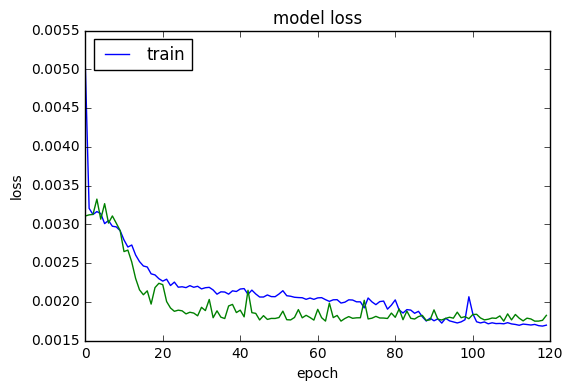

In [18]:
## Start Training
model.summary()
history_w_model = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=num_epochs, batch_size=64, validation_data=(x_valid, y_valid))

plt.plot(history_w_model.history['loss'], label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history_w_model.history['val_loss'], label='Val_loss')
plt.show()

In [ ]:
''' Save Model '''

# serialize model to JSON
model_json = model.to_json()
with open("model_V.M._2-0-p1.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
''' Load the saved model '''

# load json and create model
json_file = open('model_500x5_300e.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

In [19]:
# Notes: last best model: 0.00175
# load weights into the model
model.load_weights("best_epoch_T.M._A-2.hdf5")
print("Loaded model from disk")

model.compile(loss='mean_squared_error', optimizer='adam')

Loaded model from disk


In [20]:
''' === Prediction ===
Procedure:
1. Load CSV
2. to_datetime
3. create timeofday column
4. select the time for training: 6:00-8:00 (6 timestamps) and 15:00-17:00 (6 timestamps)
5. change it to stationary
6. Use using_cols to select the features
7. change to np array
8. MinMaxScaler
9. make the sequences tensor as input
10. make a forloop for prediction

'''
# 1. Load CSV - Vol + Route + Weather (Only Weather is 24-hour data)
df_pred = pd.read_csv('../data/preprocessed_input_interpolate_20min_phase1and2_train.csv')

# 2. to_datetime
df_pred['date'] = pd.to_datetime(df_pred['date'])

# 3. create timeofday column
df_pred['timeofday'] = df_pred.date.apply( lambda d : d.hour+d.minute/60.)

In [21]:
# Select the checking days (No need to real final test)

start_day = datetime.datetime(year=2016, month=10, day=18, hour=1, minute=0, second=0)
end_day = datetime.datetime(year=2016, month=10, day=24, hour=23, minute=0, second=0)

df_pred_sel = df_pred[(df_pred['date'] > start_day) & (df_pred['date'] < end_day)]

In [22]:
# 4. select the time for training

df_pred_sel_time = df_pred_sel[ ((df_pred_sel.timeofday>= 6) & (df_pred_sel.timeofday<8)) |
                            ((df_pred_sel.timeofday>=15) & (df_pred_sel.timeofday<17))]

df_feedin_weather_sel_time = df_pred_sel[ ((df_pred_sel.timeofday>= 8) & (df_pred_sel.timeofday<10)) |
                            ((df_pred_sel.timeofday>=17) & (df_pred_sel.timeofday<19))]

In [23]:
# Checking
df_pred_sel_time.iloc[12]

(1, 0, 'cargocar')                        0
(1, 0, 'etc')                             1
(1, 0, 'motorcycle')                      0
(1, 0, 'privatecar')                      0
(1, 0, 'tot')                            12
(1, 0, 'unknowncar')                     12
(1, 1, 'cargocar')                       28
(1, 1, 'etc')                             6
(1, 1, 'motorcycle')                     20
(1, 1, 'privatecar')                      0
(1, 1, 'tot')                            48
(1, 1, 'unknowncar')                      0
(2, 0, 'cargocar')                        0
(2, 0, 'etc')                             6
(2, 0, 'motorcycle')                      0
(2, 0, 'privatecar')                      0
(2, 0, 'tot')                            26
(2, 0, 'unknowncar')                     26
(3, 0, 'cargocar')                        0
(3, 0, 'etc')                             3
(3, 0, 'motorcycle')                      0
(3, 0, 'privatecar')                      0
(3, 0, 'tot')                   

In [24]:
# 5. change it to stationary
df_pred_sel_time = df_pred_sel_time.reset_index(drop=True)

df_pred_sel_time_copy = df_pred_sel_time.copy()

for i in range(len(df_pred_sel_time_copy)//6):  # make the loop for 14 time slots (2 different time slot x 7days)
    for t in range(5):  #  Do the "difference" 5 times every loop
        start_idx = i*6 + t + 1  # Add 1 is for starting it from index 1 in every 6-space time slot
        df_pred_sel_time_copy.loc[start_idx, df_pred_sel_time_copy.columns[0:36]] = df_pred_sel_time.loc[start_idx, df_pred_sel_time.columns[0:36]] - df_pred_sel_time.loc[start_idx-1, df_pred_sel_time.columns[0:36]]

In [25]:
# Create one-hot for it
# for i in range(24):
#     df_pred_sel_time_copy['{}:00'.format(i)] = np.where(df_pred_sel_time_copy.hour == i, 1, 0)
#     df_feedin_weather_sel_time['{}:00'.format(i)] = np.where(df_feedin_weather_sel_time.hour == i, 1, 0)

In [26]:
# 6. Use using_cols to select the features

sel_rows_pred = df_pred_sel_time_copy[ using_cols ]

sel_rows_feedin_weather = df_feedin_weather_sel_time[using_cols[output_dim:]]

In [27]:
sel_rows_pred

,"('A', 2)",hour,pressure,temperature,precipitation,dayofweek,is_holiday,timeofday
0,41.097143,6,1013.726316,19.347368,0.0,1,0,6.000000
1,2.584524,6,1013.719883,19.349123,0.0,1,0,6.333333
2,24.342619,6,1013.713450,19.350877,0.0,1,0,6.666667
3,-15.415952,7,1013.707018,19.352632,0.0,1,0,7.000000
4,3.557222,7,1013.700585,19.354386,0.0,1,0,7.333333
5,7.433016,7,1013.694152,19.356140,0.0,1,0,7.666667
6,99.960667,15,1013.552632,19.394737,0.0,1,0,15.000000
7,-11.600111,15,1013.546199,19.396491,0.0,1,0,15.333333
8,-13.474556,15,1013.539766,19.398246,0.0,1,0,15.666667
9,-11.583273,16,1013.533333,19.400000,0.0,1,0,16.000000


In [28]:
# 7. change to np array
pred_arr = sel_rows_pred.values

feedin_weather_arr = sel_rows_feedin_weather.values

# 8. MinMaxScaler
pred_arr_scaled = scaler.transform(pred_arr)

# add some dummy cells in front of the weather_array for transform
temp_arr = np.zeros((84,output_dim))
feedin_weather_arr = np.concatenate([temp_arr, feedin_weather_arr], axis=1)

feedin_weather_arr_scaled = scaler.transform(feedin_weather_arr)

# Now pred_arr_scaled is (84 x features)

In [29]:
# 9. make the sequences tensor as input
# Put into the model to get the prediction

ans_arr = []  # For holding the output answer
    
for i in range(len(pred_arr_scaled)//6):  # make the loop for 14 time slots (2 different time slot x 7days)
    # creating pre_seq
    pred_seq = []
    for t in range(5):  #  Do the "difference" 5 times every loop
        k = i*6 + t + 1  # Add 1 is for starting it from index 1 in every 6-space time slot, to ignore the first index which is non-stationary
        pred_seq.append(pred_arr_scaled[k])  # creating a sequence for a time slot
    
    # creating feedin_weather_seq
    feedin_weather_seq = []
    for t in range(6):  #  Do 6 times every loop
        k = i*6 + t  #
        feedin_weather_seq.append(feedin_weather_arr_scaled[k])


    pred_seq = np.stack(pred_seq)  # change back to the numpy array (2D)
    pred_seq = pred_seq.reshape(1, pred_seq.shape[0], pred_seq.shape[1])  # change to numpy 3D as input

    feedin_weather_seq = np.stack(feedin_weather_seq)  # change back to the numpy array (2D)
    feedin_weather_seq = feedin_weather_seq.reshape(1, feedin_weather_seq.shape[0], feedin_weather_seq.shape[1])  # change to numpy 3D as input

    for q in range(6):
        # predict next timestamp
        output_pred = model.predict(pred_seq)  # get one prediction output (size (1 x output feature(s)))
        ans_arr.append(output_pred)

        # update the input seq
        for j in range(1,5):
            pred_seq[0][j-1] = pred_seq[0][j]
        pred_seq[0][4] = feedin_weather_seq[0][q]
        pred_seq[0][4][0:output_dim] = output_pred[0]

In [30]:
# 10. Backward to the non-stationary, correct scale output

#  Helper functions

def backward_scaler(nn_output):
    tmp = np.zeros(14)
    tmp[0:output_dim] = nn_output
    tmp = scaler.inverse_transform(tmp)
    return tmp[0:output_dim]

def decode(last_timestamp_values, nn_output):
    tmp = np.zeros(input_dim)
    tmp[0:output_dim] = nn_output
    tmp = scaler.inverse_transform(tmp)
    return last_timestamp_values + tmp[0:output_dim]

# create the non-stationary 6:40 and 16:40 for decoding
df_non_station_sel_time = df_pred_sel[ ((df_pred_sel.timeofday>= 7.5) & (df_pred_sel.timeofday<8)) |
                            ((df_pred_sel.timeofday>=16.5) & (df_pred_sel.timeofday<17))]

In [31]:
''' Output the non-stationary Answers (allAns)'''

tmp = df_non_station_sel_time[using_cols[0:output_dim]].values
allAns = []
for i in range(len(tmp)):
    seed = tmp[i]  # non-stationary for reconstructing a sequence
    segmentAns = []
    for timestep in range(6):
        seed = decode(seed, ans_arr[i*6+timestep])
        segmentAns.append(seed)
    allAns.append(segmentAns)

# Change back to np array for easy visualize
allAns = np.array(allAns)

/Users/Kin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Kin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Kin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data h

In [32]:
# Checking
for i in allAns:
    print(i)

[[ 62.33660007]
 [ 63.00264395]
 [ 63.04903354]
 [ 64.32125438]
 [ 65.18828462]
 [ 65.62258279]]
[[ 81.48209208]
 [ 81.59064396]
 [ 81.64770942]
 [ 83.84267302]
 [ 84.38395697]
 [ 83.10922757]]
[[ 64.8352109 ]
 [ 67.09188251]
 [ 70.49424067]
 [ 70.38115485]
 [ 70.10855574]
 [ 71.86516543]]
[[ 64.81171441]
 [ 65.89705088]
 [ 65.67506747]
 [ 66.0307542 ]
 [ 66.9743705 ]
 [ 66.55919942]]
[[ 72.76970426]
 [ 74.7365565 ]
 [ 75.84299862]
 [ 77.02227888]
 [ 78.68952555]
 [ 79.66817911]]
[[ 63.7102102 ]
 [ 63.90416898]
 [ 64.04535417]
 [ 64.18816724]
 [ 64.32575596]
 [ 64.35160777]]
[[ 66.88988841]
 [ 67.70081359]
 [ 68.71446656]
 [ 70.68938248]
 [ 72.44171425]
 [ 73.30999379]]
[[ 84.4986984 ]
 [ 83.27206717]
 [ 84.5002974 ]
 [ 84.7491498 ]
 [ 84.13193235]
 [ 84.0447601 ]]
[[ 77.08714304]
 [ 76.13679706]
 [ 76.27169788]
 [ 78.32471417]
 [ 80.46934601]
 [ 81.35401791]]
[[ 68.60753936]
 [ 67.94112588]
 [ 68.62556858]
 [ 68.51308848]
 [ 68.12506135]
 [ 67.70453342]]
[[ 63.87021412]
 [ 63.97181912

In [33]:
# 11. Output the CSV file

# create the datetime objects
import datetime

pred_start_date = 18


start_8am = datetime.datetime(year=2016, month=10, day=pred_start_date, hour=8, minute=0, second=0)
start_5pm = datetime.datetime(year=2016, month=10, day=pred_start_date, hour=17, minute=0, second=0)
add_1_day = datetime.timedelta(days=1)
add_20_min = datetime.timedelta(minutes=20)

'''
allAns[x,y,z]
[x]: Segment (AM & PM, total 14)
[y]: timestamp (6 [20mins])
[z]: 3 features
'''
# allAns[0,:,1]

'\nallAns[x,y,z]\n[x]: Segment (AM & PM, total 14)\n[y]: timestamp (6 ins])\n[z]: 3 features\n'

In [34]:
# 11.a [FOR TRAFFIC TIME] Output the CSV file

route = 'A'
checkpoint = '2'
vol_or_traj = 0  # select the output cell

with open('{}-{}_checking_A-2_single.csv'.format(route, checkpoint), 'w') as f:
    for day in range(7):
        for am_pm in range(2):
            if am_pm == 0:
                ref_time = start_8am
            else:
                ref_time = start_5pm
            for timestep in range(6):
                start_timestamp = ref_time + day*add_1_day + timestep*add_20_min
                end_timestamp = start_timestamp + add_20_min
                start_timestr = start_timestamp.strftime("%Y-%m-%d %H:%M:00")
                end_timestr = end_timestamp.strftime("%Y-%m-%d %H:%M:00")
                f.write('{},{},"[{},{})",{}\n'.format(route,
                                                      checkpoint,
                                                      start_timestr,
                                                      end_timestr,
                                                      allAns[day*2+am_pm, timestep, vol_or_traj ]))

In [364]:
# 11.b [FOR VOLUME] Output the CSV file

checkpoint = '2'
direction = '0'
vol_or_traj = 1  # select the output cell

with open('{}-{}.csv'.format(checkpoint, direction), 'w') as f:
    for day in range(7):
        for am_pm in range(2):
            if am_pm == 0:
                ref_time = start_8am
            else:
                ref_time = start_5pm
            for timestep in range(6):
                start_timestamp = ref_time + day*add_1_day + timestep*add_20_min
                end_timestamp = start_timestamp + add_20_min
                start_timestr = start_timestamp.strftime("%Y-%m-%d %H:%M:00")
                end_timestr = end_timestamp.strftime("%Y-%m-%d %H:%M:00")
                f.write('{},"[{},{})",{},{}\n'.format(checkpoint,
                                                  start_timestr,
                                                  end_timestr,
                                                  direction,
                                                  allAns[day*2+am_pm, timestep, vol_or_traj ]))